In [9]:
import pandas as pd
import numpy as np
base_line_data = pd.read_csv("../DBtrainrides_complete_preprocessed_2.csv")
# Drop all delay based features except for the target variable arrival_delay_m
base_line_data.drop(columns=["arrival_plan","departure_plan","prev_arrival_delay_m","prev_departure_delay_m", "weighted_avg_prev_delay", "info_label_encoded", "arrival_normalized", "departure_normalized"],inplace=True)

# Encode info_messages
message_order = ['No message', 'Information', 'Bauarbeiten', 'Störung', 'Großstörung']

base_line_data['transformed_info_message'] = pd.Categorical(
    base_line_data['transformed_info_message'],
    categories=message_order,
    ordered=True
)
base_line_data['transformed_info_message'] = base_line_data['transformed_info_message'].cat.codes

# Fill arrival_delay_m NaN values with 0
base_line_data["arrival_delay_m"] = base_line_data["arrival_delay_m"].fillna(0.0)
# Step 1: Create a unique identifier for groups
base_line_data['Group'] = base_line_data['ID_Base'].astype(str) + "_" + base_line_data['ID_Timestamp'].astype(str)

# Step 2: Get unique groups and shuffle them
unique_groups = base_line_data['Group'].unique()
np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_groups)

# Step 3: Split groups into train and test
split_idx = int(0.8 * len(unique_groups))  # 80-20 split
train_groups = unique_groups[:split_idx]
test_groups = unique_groups[split_idx:]

# Step 4: Assign rows to train and test sets
train_data = base_line_data[base_line_data['Group'].isin(train_groups)]
test_data = base_line_data[~base_line_data['Group'].isin(train_groups)]

# Step 5: Get train and test targets
train_target = train_data["arrival_delay_m"]
test_target = test_data["arrival_delay_m"]

# Drop the helper column if necessary
train_data = train_data.drop(columns=['Group','arrival_delay_m'])
test_data = test_data.drop(columns=['Group', 'arrival_delay_m'])
train_data


,ID_Base,ID_Timestamp,stop_number,IBNR,long,lat,transformed_info_message,max_station_number,station_progress
0,-1001326572688500578,2407082041,2,8011118.0,13.375988,52.509379,0,7,0.285714
1,-1001326572688500578,2407082041,3,8011160.0,9.095851,48.849792,0,7,0.428571
2,-1001326572688500578,2407082041,4,8011167.0,13.299437,52.530276,0,7,0.571429
3,-1001326572688500578,2407082041,5,8010404.0,13.196898,52.534648,0,7,0.714286
4,-1001326572688500578,2407082041,6,8080040.0,13.128917,52.549396,0,7,0.857143
...,...,...,...,...,...,...,...,...,...
1914111,999976718847540977,2407100447,6,8005649.0,7.110814,49.274763,0,6,1.000000
1914112,999976718847540977,2407120447,2,8005241.0,7.018788,49.230425,0,6,0.333333
1914113,999976718847540977,2407120447,3,8005306.0,8.243728,50.070788,0,6,0.500000
1914114,999976718847540977,2407120447,4,8005332.0,7.057083,49.244018,0,6,0.666667


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

scaler = StandardScaler()
df_features_train_scaled = scaler.fit_transform(train_data)
train_target_scaled = scaler.fit_transform(train_target.values.reshape(-1, 1))

# Convert back to a pandas Series if needed
train_target_scaled = pd.Series(train_target_scaled.flatten())

regression_tree = DecisionTreeRegressor()
# Train on scaled data
regression_tree.fit(df_features_train_scaled, train_target)

# Predict on the test data
test_predictions = regression_tree.predict(test_data)

# Calculate Mean Squared Error as a performance metric
mse = mean_squared_error(test_target, test_predictions)
mae = mean_absolute_error(test_target, test_predictions)
r2 = r2_score(test_target, test_predictions)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2: ", r2)
# Mean Squared Error: 8.003450359220416
# Mean Absolute Error: 1.0899843909791496
# Worse than predicting the average delay in the dataset

Mean Squared Error: 10.319089356147964
Mean Absolute Error: 1.7927182812585314
R2:  -0.04842241164906369


/home/tu2/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


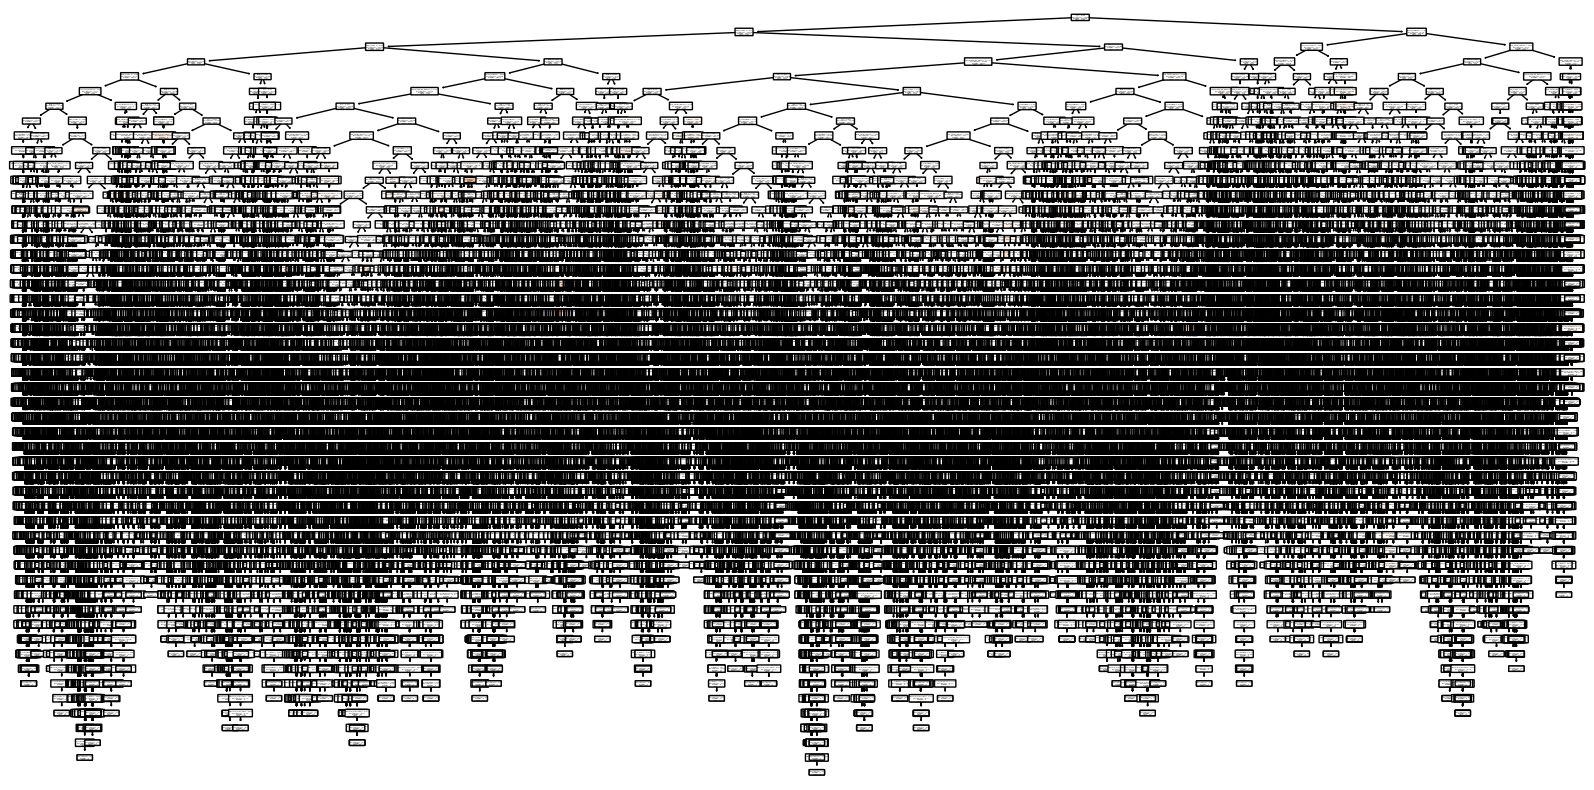

In [3]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming 'regressor' is your trained DecisionTreeRegressor
plt.figure(figsize=(20, 10))  # Adjust size as needed for readability
plot_tree(regression_tree, feature_names=train_data.columns, filled=True, rounded=True)
plt.show()


# Spatial RMSE

/tmp/ipykernel_39312/1650896092.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_mse = data.groupby(['lat_bin', 'lon_bin'])['squared_error'].mean().reset_index()


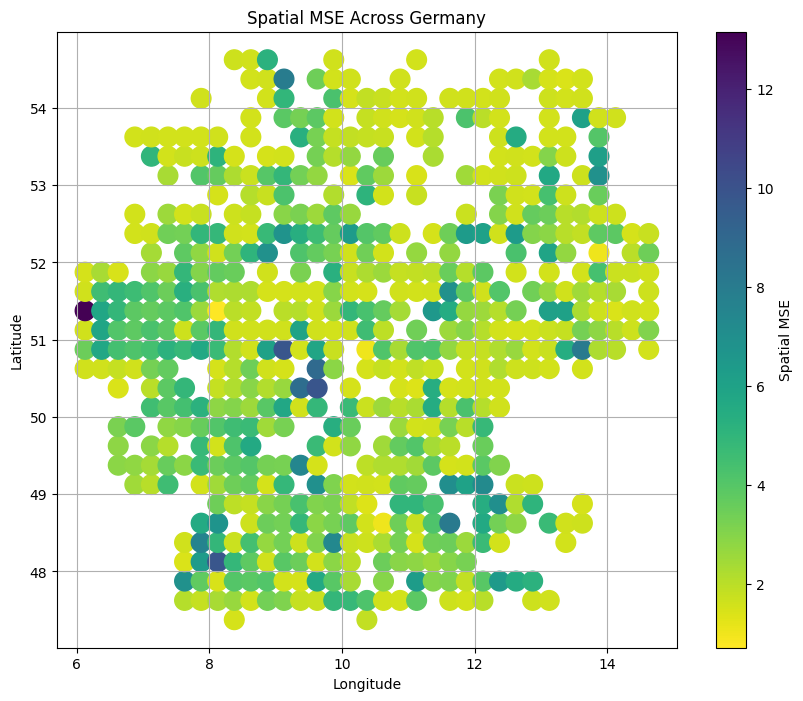

Overall Spatial RMSE: 3.0014567601463447


In [12]:
# Spatial MSE
# Define Germany's approximate geographic boundaries
germany_bounds = {
    'min_lat': 47.0, 'max_lat': 55.0,  # Latitude range
    'min_lon': 5.0, 'max_lon': 15.0  # Longitude range
}


# Create a grid over Germany
def create_grid(bounds, cell_size):
    lat_edges = np.arange(bounds['min_lat'], bounds['max_lat'], cell_size)
    lon_edges = np.arange(bounds['min_lon'], bounds['max_lon'], cell_size)
    return lat_edges, lon_edges


# Define grid cell size (in degrees)
cell_size = 0.25  # Adjust for desired resolution
lat_edges, lon_edges = create_grid(germany_bounds, cell_size)

# Assign test data points to grid cells
test_data['lat_bin'] = pd.cut(test_data['lat'], bins=lat_edges)
test_data['lon_bin'] = pd.cut(test_data['long'], bins=lon_edges)

# Combine with y_test and y_pred
data = pd.DataFrame({
    'lat_bin': test_data['lat_bin'],
    'lon_bin': test_data['lon_bin'],
    'y_test': test_target,
    'y_pred': test_predictions  # Using predictions from Linear Regression as an example
})

# Compute squared error
data['squared_error'] = (data['y_test'] - data['y_pred']) ** 2

# Group by grid cells and compute MSE
spatial_mse = data.groupby(['lat_bin', 'lon_bin'])['squared_error'].mean().reset_index()
spatial_mse.rename(columns={'squared_error': 'spatial_mse'}, inplace=True)
spatial_mse['spatial_mse'] = np.sqrt(spatial_mse['spatial_mse'])

# Add grid cell centres for visualisation
spatial_mse['lat_center'] = spatial_mse['lat_bin'].apply(lambda x: x.mid)
spatial_mse['lon_center'] = spatial_mse['lon_bin'].apply(lambda x: x.mid)

# Visualise Spatial MSE
plt.figure(figsize=(10, 8))
plt.scatter(spatial_mse['lon_center'], spatial_mse['lat_center'], c=spatial_mse['spatial_mse'], cmap='viridis_r', s=200)
plt.colorbar(label='Spatial MSE')
plt.title('Spatial MSE Across Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

# Overall Spatial MSE
overall_spatial_mse = spatial_mse['spatial_mse'].mean()
print(f"Overall Spatial RMSE: {overall_spatial_mse}")